# Evaluación de Modelos

## Métricas de Puntuación y Manejo de Conjunto de Datos no Balanceados

Hasta el momento se ha visto como evaluar el modelo y seleccionar el mejor posible. Se ha asumido la medida de rendimiento para medir la calidad del modelo, pero en la realidad, no es claro cuál debería ser. Por defecto scikit_learn usa el **accuracy** para clasificación (radio de clases correctamente clasificados) y el $R^2$ (Coeficiente de determinación) para regresión. Estas medidas son razonables para la mayoría de escenarios. Sin embargo, depende de la tarea con la que se este tratando, y las opciones anteriores no siempre tienen que ser la mejores y en ocasiones pueden ser poco recomendadas. 

En esta sección se retomará el problema de clasificación de dígitos manuscritos y se usará **sklearn.metrics** para ayudar a entrenar el clasificador y evaluarlo de diferentes maneras.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=2)

In [17]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

digitos = load_digits()
X, y = digitos.data, digitos.target
class_names = digitos.target_names

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y, test_size=0.25)

clasificador = LinearSVC(random_state=1, dual=False)
clasificador.fit(X_train, y_train)

y_test_pred = clasificador.predict(X_test)

print(f"CCR: {clasificador.score(X_test, y_test)}")

CCR: 0.9488888888888889


La predicción nos entrega un muy buen resultado. Para probemas **multi-clase**, a veces es muy útil saber qué clases son más difíciles de predecir y cuáles más fáciles o incluso qué tipo de errores son los más comunes. Para esto se va a construir la **Matriz de Confusión**, la cual muestra para cada clase(fila) cuántas veces se predicen qué clases (columnas).

In [18]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred)

array([[43,  0,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 0, 43,  0,  0,  0,  0,  1,  0,  2,  0],
       [ 0,  1, 43,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 45,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0, 43,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  0, 42,  1,  1,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 44,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 43,  1,  0],
       [ 0,  3,  0,  1,  0,  0,  0,  0, 37,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0, 44]], dtype=int64)

Los gráficos son más fáciles de interpretar:

array([[43,  0,  0,  0,  1,  0,  0,  0,  0,  1],
       [ 0, 43,  0,  0,  0,  0,  1,  0,  2,  0],
       [ 0,  1, 43,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 45,  0,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0, 43,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  0, 42,  1,  1,  0,  1],
       [ 0,  0,  0,  0,  0,  1, 44,  0,  0,  0],
       [ 0,  0,  0,  0,  1,  0,  0, 43,  1,  0],
       [ 0,  3,  0,  1,  0,  0,  0,  0, 37,  2],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0, 44]], dtype=int64)

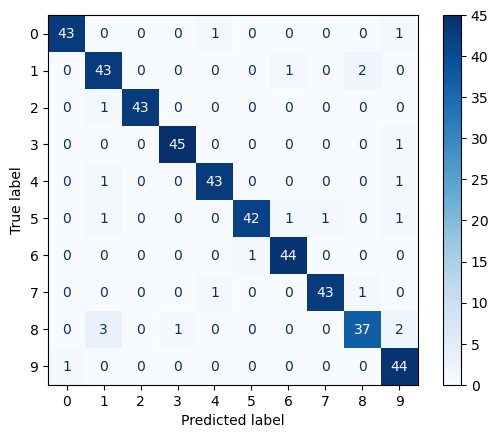

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(clasificador,
        X_test,y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues)

disp.confusion_matrix

Se observa que la mayoría de valores están en la diagonal principal, lo que significa que se puede predecir casi todos los ejemplos correctamente. Las entradas que no están en la diagonal principal muestran que hay 8's clasificados como 1's y que 9's con muchas otras clases.

Otra función útil es **classification_report** que proporciona los valores de precisión, recall, puntuación f y el soporte para todas las clases. La precisión dice cuantas de las predicciones de una clase, son realmente de esta. Sea TP, FP, TN, FN "True Positive", "False Positive", "True Negative" y "False Negative", respectivamente:

$$
Precision = TP/(TP + FP)
$$

El recall representa cuantos ejemplos de la clase fueron clasificados correctamente - Accuracy considerando solo esa clase.

$$
Recall = TP/(TP + FN)
$$

El valor F1 es la media geométrica de la precisión y el recall:

$$
F1 = 2 x (precision x recall) / (precision + recall)
$$

Todas estas métricas están en el intervalo $[0, 1]$, donde 1 es una puntuación perfecta.

In [7]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97        45
           1       0.88      0.93      0.91        46
           2       1.00      0.98      0.99        44
           3       0.98      0.98      0.98        46
           4       0.96      0.96      0.96        45
           5       0.98      0.91      0.94        46
           6       0.96      0.98      0.97        45
           7       0.98      0.96      0.97        45
           8       0.93      0.86      0.89        43
           9       0.88      0.98      0.93        45

    accuracy                           0.95       450
   macro avg       0.95      0.95      0.95       450
weighted avg       0.95      0.95      0.95       450



Estas métricas son especialmente útiles en dos casos particulares:

1. Clasificación no balanceada, es decir, una o varias clases son mucho menos frecuentes (hay menos casos en el conjunto de entrenamiento) que el resto de clases.

2. Costes asimétricos, esto es, algunos tipos de errores son más "costosos" que el resto.

En el primer caso, imagine que se tiene un ratio de 1:9 para un problema de clasificación (lo cual no es muy exagerado).

In [8]:
np.bincount(y) / y.shape[0]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Para probar este escenario, vamos a clasificar el dígito 3 contra el resto (el problema de clasificación es un problema binario, ¿es este dígito un 3?):

In [10]:
X, y = digitos.data, digitos.target == 3

Ahora vamos a aplicar validación cruzada con un clasificador para ver que tal funciona:

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

cross_val_score(SVC(), X, y)

array([1.  , 0.96, 1.  , 1.  , 0.96])

Nuestro clasificador tiene más de 90% de acierto siempre. ¿Es bueno o malo? Ten en cuenta que el 90% de los dígitos no son un 3. Vamos a ver que tal funciona un clasificador simple, que siempre predice la clase más frecuenta (ZeroR):

In [12]:
from sklearn.dummy import DummyClassifier

cross_val_score(DummyClassifier(strategy="most_frequent"), X, y)

array([0.9, 0.9, 0.9, 0.9, 0.9])

También un 90%, como esperábamos. Por tanto, podemos pensar que el clasificador SVC no es demasiado bueno, ya que funciona igual que una estrategia que ni si quiera mira los datos de entrada. De todas formas, esto sería sacar conclusiones muy rápido ya que, en general, **el accuracy no es una buena medida de rendimiento para bases de datos no balanceadas**.